In [1]:
for var in list(globals()):
    if var.startswith('df'):
        del globals()[var]

print("🧼 נמחקו כל המשתנים שמתחילים ב־df")
%reset -f

🧼 נמחקו כל המשתנים שמתחילים ב־df


#במחברת הזאת הוספתי הספק של ה BESS#

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


# שלב ראשון לוקחת 17 עמודות והופכת אותם ל 76 עמודות

In [3]:
# קלט קבועים
site_capacity_kwp = 15200
grid_connection_limit_kw = 6000
bess_capacity_kwh =0.99* 35000
bess_charge_limit_kw = 6000
target_soc = 0.99
site_pv_limit=grid_connection_limit_kw+bess_charge_limit_kw
pv_start_hour=8
pv_end_hour=16





In [4]:
#import os

# קלט קבועים
site_capacity_kwp = 15200
grid_connection_limit_kw = 6000
bess_capacity_kwh = 0.99 * 35000
bess_charge_limit_kw = 6000
target_soc = 0.99
site_pv_limit = grid_connection_limit_kw + bess_charge_limit_kw
pv_start_hour = 8
pv_end_hour = 16

# טעינת הקובץ או יצירת נתוני דמה
if os.path.exists("Project data4.xlsx"):
    df = pd.read_excel("Project data4.xlsx")
    print("✅ Loaded real data.")
else:
    from generate_dummy_data_daylight_clean_10k import generate_dummy_data
    df = generate_dummy_data()
    print("⚠️ Using dummy data (real data file not found).")

⚠️ Using dummy data (real data file not found).


In [5]:
#סידור עמודות
#אייצר 17 עמודות מקבילות לעמודות המקור שבכל אחת מהם מצויין 1 או 0 אם  בעמודת המקור יש ערך חסר
for col in df.columns:
    df[f'{col}_missing'] = df[col].isna().astype(int)

#מורידה רווחים בעמודות
df.columns = df.columns.str.strip()


In [6]:
#מילויי ערכים חסרים בעמודות מקור

# עמודות למילוי בערך קבוע (0)
fill_zero_columns = [
    "BESS availability",
    "Inv Block1-Availability",
    "Inv Block2-Availability",
    "Power Plant Control"
    "POC BESS-Power (BESS Meter) min"
]

# עמודות לטיפול באינטרפולציה לינארית
linear_interp_columns = [
    "SOC",
    "BESS Meter-Exported Energy",
    "BESS Meter-Imported Energy",
    "Grid Meter-Exported Energy",
    "Grid Meter-Imported Energy",
    "PV Meter-Exported Energy",
    "PV Meter-Imported Energy",
    "Irradiance1",
    "Irradiance2",
    "Temperature 1",
    "Temperature2"
]

# טיפול בערכים חסרים לפי ההוראות
for col in fill_zero_columns:
    if col in df.columns:
        df[col] = df[col].fillna(0)

for col in linear_interp_columns:
    if col in df.columns:
        df[col] = df[col].interpolate(method='linear', limit_direction='both')



In [7]:
# קרינה ממוצעת
df['irradiance_avg'] = (df['Irradiance1'] + df['Irradiance2']) / 2
df['site_power_potential'] = 15200 * (df['irradiance_avg'] / 1000)
df['surplus_power'] = (df['site_power_potential'] - 6000).clip(lower=0)
df['actual_bess_charge_power'] = df['surplus_power'].clip(upper=bess_charge_limit_kw)
df['actual_bess_charge_energy'] = df['actual_bess_charge_power'] * 0.25

#   והקרינה הממוצעת חישוב הפרשים לכל עמודות המקור
for col in df.columns:
    if df[col].dtype in [np.float64, np.int64]:
        df[f"delta_{col}"] = df[col].diff()

 שלב 2: בדיקה של ניקוי הנתונים והכנסת הקובץ

In [8]:
print("🔍 מבנה כללי של df:")
df.info()
print("\n🧾 סטטיסטיקות כלליות:")
print(df.describe())

# סיכום ערכים חסרים
print("\n📉 כמות NaN בכל עמודה:")
print(df.isna().sum().sort_values(ascending=False))

# חיפוש ערכים אינסופיים
print("\n⚠️ בדיקת ערכי inf או -inf:")
print(np.isinf(df.select_dtypes(include=[np.number])).sum())

# בדיקת עמודות כפולות
print("\n🧩 בדיקת עמודות כפולות:")
duplicated_cols = df.columns[df.T.duplicated()]
print(duplicated_cols)

🔍 מבנה כללי של df:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 77 columns):
 #   Column                                         Non-Null Count  Dtype         
---  ------                                         --------------  -----         
 0   Date                                           10000 non-null  datetime64[ns]
 1   SOC                                            10000 non-null  float64       
 2   BESS availability                              10000 non-null  float64       
 3   Inv Block1-Availability                        10000 non-null  float64       
 4   Inv Block2-Availability                        10000 non-null  float64       
 5   BESS Meter-Exported Energy                     10000 non-null  float64       
 6   BESS Meter-Imported Energy                     10000 non-null  float64       
 7   Grid Meter-Exported Energy                     10000 non-null  float64       
 8   Grid Meter-Imported Energy            

In [9]:
#df = df.dropna()
# סינון העמודות שרוצים להסיר
cols_to_drop = [col for col in df.columns if col.startswith('delta_') and col.endswith('_missing')]

# הסרת העמודות
df = df.drop(columns=cols_to_drop)

print(f"הוסרו {len(cols_to_drop)} עמודות: {cols_to_drop}")

binary_cols = ['is_weekend', 'suspected_blackout', 'is_peak_time', 'bess_is_full', 'valid_for_PR']
existing_cols = [col for col in binary_cols if col in df.columns]
df[existing_cols] = df[existing_cols].apply(pd.to_numeric, errors='coerce')

הוסרו 17 עמודות: ['delta_Date_missing', 'delta_SOC_missing', 'delta_BESS availability_missing', 'delta_Inv Block1-Availability_missing', 'delta_Inv Block2-Availability_missing', 'delta_BESS Meter-Exported Energy_missing', 'delta_BESS Meter-Imported Energy_missing', 'delta_Grid Meter-Exported Energy_missing', 'delta_Grid Meter-Imported Energy_missing', 'delta_PV Meter-Exported Energy_missing', 'delta_PV Meter-Imported Energy_missing', 'delta_Power Plant Control_missing', 'delta_Irradiance1_missing', 'delta_Temperature 1_missing', 'delta_Irradiance2_missing', 'delta_Temperature2_missing', 'delta_POC BESS-Power (BESS Meter) min_missing']


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 60 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Date                                     10000 non-null  datetime64[ns]
 1   SOC                                      10000 non-null  float64       
 2   BESS availability                        10000 non-null  float64       
 3   Inv Block1-Availability                  10000 non-null  float64       
 4   Inv Block2-Availability                  10000 non-null  float64       
 5   BESS Meter-Exported Energy               10000 non-null  float64       
 6   BESS Meter-Imported Energy               10000 non-null  float64       
 7   Grid Meter-Exported Energy               10000 non-null  float64       
 8   Grid Meter-Imported Energy               10000 non-null  float64       
 9   PV Meter-Exported Energy                

In [11]:
df.shape[1]

60

In [12]:

#  והוספת עמודות

df['datetime'] = pd.to_datetime(df['Date'])
df['hour'] = df['datetime'].dt.hour + df['datetime'].dt.minute / 60
df['date'] = df['datetime'].dt.date

df['minute'] = df['Date'].dt.minute
df['dayofweek'] = df['Date'].dt.dayofweek
df['is_weekend'] = df['dayofweek'] >= 5
df['month'] = df['Date'].dt.month
df['abs_POC_BESS_Power'] = df['POC BESS-Power (BESS Meter) min'].abs()


# התיחסות לזמינויות
df['bess_available'] = (df['BESS availability'] == 100).astype(int)
df['pv_available'] = ((df['Inv Block1-Availability'] == 100) &
                      (df['Inv Block2-Availability'] == 100)).astype(int)
# שלב 1: חישוב ראשוני של grid ratio
df['grid_ratio'] = df['Power Plant Control'] / grid_connection_limit_kw

# שלב 2: תנאי לחשד להפסקת חשמל
# נניח ש-pv_energy הוא עמודה קיימת (למשל PV Meter-Exported Energy)
df['suspected_blackout'] = (
    df['bess_available'].isna() &
    df['pv_available'].isna() &
    df['irradiance_avg'].isna() &
    (df['PV Meter-Exported Energy'] == 0)
)

# שלב 3: קביעת זמינות רשת לפי תנאים
df['grid_available'] = (
    ((df['grid_ratio'] < 1) | df['suspected_blackout'])
).astype(int)



In [13]:
##test1
# שלב 4: חישוב שעת פסגה לפי טבלת קבועים
peak_config = {
    1: (17, 22), 2: (17, 22), 3: (17, 22), 4: (17, 22), 5: (17, 22),
    6: (17, 23), 7: (17, 23), 8: (17, 23), 9: (17, 23),
    10: (17, 22), 11: (17, 22), 12: (17, 22)
}
df['is_peak_time'] = df.apply(lambda row: peak_config[row['month']][0] <= row['hour'] < peak_config[row['month']][1], axis=1)

def get_operation_zone(row):
    if  6 <= row['hour'] <= 16:
        return 'PV_active'
    elif row['is_peak_time']:
        return 'Discharge_peak'
    else:
        return 'Free_night'

df['operation_zone'] = df.apply(get_operation_zone, axis=1)

# שלב 6: חישוב הפרשים לכל עמודות המקור
#for col in df.columns:
    #if df[col].dtype in [np.float64, np.int64]:
      #  df[f"delta_{col}"] = df[col].diff()
#מעכשיו נתעלם כל יום מהשעה 00:15
mask = df['Date'].dt.time != pd.to_datetime("00:15").time()
df_filtered = df[mask]




In [14]:
# שלב 5: חישובים נוספים





# ---------- שלב ב': חישובי פיצ'רים ---------- #

# בדיקת האם הסוללה מלאה
df['bess_is_full'] = df['SOC'] >= 0.96

# האם רבע השעה תקפה לחישוב PR (לא כשאין זמינות או שהסוללה מלאה)
df['valid_for_PR'] = (
    df['bess_available']
    & df['grid_available']
    & (~df['bess_is_full'])
)

# הגבלת ההספק הפוטנציאלי למקסימום המותר
df['target'] = df['site_power_potential'].clip(upper=site_pv_limit)

# יחס בין ייצור בפועל למקסימום אפשרי – Target Rate
df['target_rate'] = df['delta_PV Meter-Exported Energy'] / df['target']

# חישוב PR לפי קרינה והספק מותקן
df['PR'] = (
    df['delta_PV Meter-Exported Energy']
    / ((df['irradiance_avg'] / 4000) * site_capacity_kwp)
)
df['target_rate'] = np.nan_to_num(df['target_rate'], nan=0.0, posinf=0.0, neginf=0.0)
df['PR'] = np.nan_to_num(df['target_rate'], nan=0.0, posinf=0.0, neginf=0.0)


# אינדיקציה למי קיבל עדיפות קודם: גריד או סוללה
df['first_grid_act'] = (
    df['delta_Grid Meter-Exported Energy'] > df['delta_BESS Meter-Imported Energy']
).astype(int)

df['first_bess_act'] = (
    df['delta_Grid Meter-Exported Energy'] < df['delta_BESS Meter-Imported Energy']
).astype(int)

In [15]:
# שלב 6: חישובים נוספים
df['first_grid_act'] = (df['delta_Grid Meter-Exported Energy'] > df['delta_BESS Meter-Imported Energy']).astype(int)
df['first_bess_act'] = (df['delta_Grid Meter-Exported Energy'] < df['delta_BESS Meter-Imported Energy']).astype(int)




In [16]:


    # חישוב מצב נוכחי בסוללה ואנרגיה נדרשת
    df['energy_in_bess_kwh'] = df['SOC'] * bess_capacity_kwh
    df['energy_needed_kwh'] = (target_soc * bess_capacity_kwh) - df['energy_in_bess_kwh']

    # חישוב כמות דקות נותרות עד 16:30
    CHARGE_END_MINUTES = 16 * 60 + 30
    df['time_in_minutes'] = df['datetime'].dt.hour * 60 + df['datetime'].dt.minute
    df['quarters_left'] = ((CHARGE_END_MINUTES - df['time_in_minutes']) / 15).clip(lower=0).astype(int)

    df.loc[0] = df.loc[0].replace([np.inf, -np.inf], np.nan).fillna(0)

In [17]:
# הגנה על denominator
df = df.copy()

# טיפול במכנה: אם הוא 0, נחליף ב־NaN כדי להימנע מחלוקה באפס
df['energy_needed_kwh'] = df['energy_needed_kwh'].fillna(0)

# חישוב כמות רבעי השעה הדרושים לטעינה מלאה של הסוללה
#df['required_quarters'] = df['energy_needed_kwh'] / df['delta_BESS Meter-Imported Energy']
#df['required_quarters'] = (df['energy_needed_kwh'] /
                    #       df['abs_POC_BESS_Power'].where(df['abs_POC_BESS_Power'] > 0, 1)) * 4

df['required_quarters'] = (df['energy_needed_kwh'] /
                           df['abs_POC_BESS_Power'].mask(df['abs_POC_BESS_Power'] < 1, 1)) * 4

#df['required_quarters'] = df['required_quarters'].replace([np.inf, -np.inf], np.nan).fillna(0)

# חישוב עדיפות לסוללה: האם יש מספיק זמן עד סוף היום כדי לטעון את הסוללה
df['BESS First'] = (df['required_quarters'] > df['quarters_left']).astype(int)

# רק לשורה הראשונה: מילוי ערכים חסרים או אינסופיים
df.loc[0] = df.loc[0].replace([np.inf, -np.inf], np.nan).fillna(0)


In [18]:
#בודקת כמה עמודות יצרתי
df.shape[1]

88

In [19]:
df.to_excel("Stage2.xlsx", index=False)

שלב 2 נבחר את העמודות הכי רלוונטיות בעזרת random forest

In [20]:
df['date'] = pd.to_datetime(df['date']).map(lambda x: x.timestamp())
df_step1 = df.drop(columns=['Date','datetime', 'operation_zone'])
df_step1 = df_step1.dropna()


In [21]:
missing_rows = df_step1.isna().any(axis=1).sum()
print(f"מספר שורות עם ערכים חסרים: {missing_rows}")

מספר שורות עם ערכים חסרים: 0


In [22]:
# 3. שלב שני: Feature Selection לפי חשיבות בפועל – Random Forest
# נגדיר X ו־y


# יצירת עמודת 'BESS First' עם ערך התחלתי אפס (למניעת NaN)
#df_step1['BESS First'] = 0

# כאן אפשר להכניס תנאי חכם ולהחליף ל־1 היכן שצריך
# לדוגמה (אם יש לך חישוב לפי required_quarters וכו')
 #df_step1.loc[condition, 'BESS First'] = 1

# סינון לפי שעות (9– 6)
df_filtered = df_step1[(df_step1['hour'] >= 9) & (df_step1['hour'] <= 16)]

# הסרה של שורות עם NaN, אם בטעות נותרו
df_filtered = df_filtered.dropna(subset=['BESS First'])

# יצירת X ו־y על בסיס עמודות מספריות בלבד
X = df_filtered.select_dtypes(include='number').drop(columns=['BESS First'])
y = df_filtered['BESS First'].astype(int)



In [23]:
df.shape[1]
missing_rows = df_filtered.isna().any(axis=1).sum()
print(f"מספר שורות עם ערכים חסרים: {missing_rows}")

מספר שורות עם ערכים חסרים: 0


In [24]:
# אימון מודל
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=2,
    max_leaf_nodes=50,
    random_state=42
)
rf.fit(X, y)

# בחירת פיצ'רים חשובים בלבד
selector = SelectFromModel(rf, prefit=True)
X_selected = selector.transform(X)

# שמות הפיצ'רים שנבחרו
selected_features = X.columns[selector.get_support()].tolist()
print(f"\n✔️ נבחרו {len(selected_features)} פיצ'רים חשובים:")
print(selected_features)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(



✔️ נבחרו 11 פיצ'רים חשובים:
['SOC', 'POC BESS-Power (BESS Meter) min', 'delta_SOC', 'delta_POC BESS-Power (BESS Meter) min', 'hour', 'abs_POC_BESS_Power', 'energy_in_bess_kwh', 'energy_needed_kwh', 'time_in_minutes', 'quarters_left', 'required_quarters']


In [25]:
manual_features = ['target_rate', 'SOC', 'hour','month']  # לדוגמה
X_manual = X[manual_features]
X_auto = X.drop(columns=manual_features)

# Apply Feature Selection רק על X_auto
rf.fit(X_auto, y)
selector = SelectFromModel(rf, prefit=True)
auto_selected = X_auto.columns[selector.get_support()].tolist()

# איחוד סופי
selected_features = manual_features + auto_selected

print(selected_features)

['target_rate', 'SOC', 'hour', 'month', 'POC BESS-Power (BESS Meter) min', 'delta_SOC', 'delta_POC BESS-Power (BESS Meter) min', 'abs_POC_BESS_Power', 'energy_in_bess_kwh', 'energy_needed_kwh', 'time_in_minutes', 'quarters_left', 'required_quarters']


In [26]:
missing_rows = X_auto.isna().any(axis=1).sum()
print(f"מספר שורות עם ערכים חסרים: {missing_rows}")

מספר שורות עם ערכים חסרים: 0


In [ ]:
print("יש NaN?", X.isna().sum().sum())
print("יש inf?", (X == np.inf).sum().sum())
print("יש -inf?", (X == -np.inf).sum().sum())
missing_rows = X.isna().any(axis=1).sum()
print(f"מספר שורות עם ערכים חסרים: {missing_rows}")

יש NaN? 0
יש inf? 0
יש -inf? 0
מספר שורות עם ערכים חסרים: 0


In [27]:
#df_selected_final = df_selected_final.replace(['', ' ', 'nan', 'None'], np.nan)

# יצירת DataFrame סופי


df_filtered = df[(df['hour'] >= 9) & (df['hour'] < 16)].dropna(subset=['BESS First'])

# יצירת X ו-y
X = df_filtered[selected_features]
y = df_filtered['BESS First'].astype(int)

# איפוס אינדקס
X_reset = X.reset_index(drop=True)
y_reset = y.reset_index(drop=True)

# חיבור שני החלקים ל-DataFrame אחד
df_selected_final = pd.concat([X_reset, y_reset], axis=1)


#df_selected_final = pd.concat([X[selected_features], y.reset_index(drop=True)], axis=1)

In [28]:
missing_rows = df_selected_final.isna().any(axis=1).sum()
print(f"מספר שורות עם ערכים חסרים: {missing_rows}")

מספר שורות עם ערכים חסרים: 0


In [29]:
num_rows_with_nan = df_selected_final.isna().any(axis=1).sum()
print(f"מספר שורות עם ערכים חסרים (NaN): {num_rows_with_nan}")

מספר שורות עם ערכים חסרים (NaN): 0


In [30]:
df_selected_final[df_selected_final.isna().any(axis=1)].index

Index([], dtype='int64')

In [31]:
df_selected_final[df_selected_final.isna().any(axis=1)].isna()

,target_rate,SOC,hour,month,POC BESS-Power (BESS Meter) min,delta_SOC,delta_POC BESS-Power (BESS Meter) min,abs_POC_BESS_Power,energy_in_bess_kwh,energy_needed_kwh,time_in_minutes,quarters_left,required_quarters,BESS First


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    X[selected_features], y, test_size=0.2, stratify=y, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
# רמת דיוק בסיסית
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")



              precision    recall  f1-score   support

           0       0.98      0.98      0.98       266
           1       0.98      0.98      0.98       320

    accuracy                           0.98       586
   macro avg       0.98      0.98      0.98       586
weighted avg       0.98      0.98      0.98       586

Accuracy: 0.981


                                  Feature  Importance
12                      required_quarters    0.268287
7                      abs_POC_BESS_Power    0.097467
10                        time_in_minutes    0.094338
4         POC BESS-Power (BESS Meter) min    0.092659
11                          quarters_left    0.091754
2                                    hour    0.081015
9                       energy_needed_kwh    0.079328
8                      energy_in_bess_kwh    0.077997
1                                     SOC    0.071950
5                               delta_SOC    0.017881
6   delta_POC BESS-Power (BESS Meter) min    0.016533
0                             target_rate    0.008205
3                                   month    0.002587


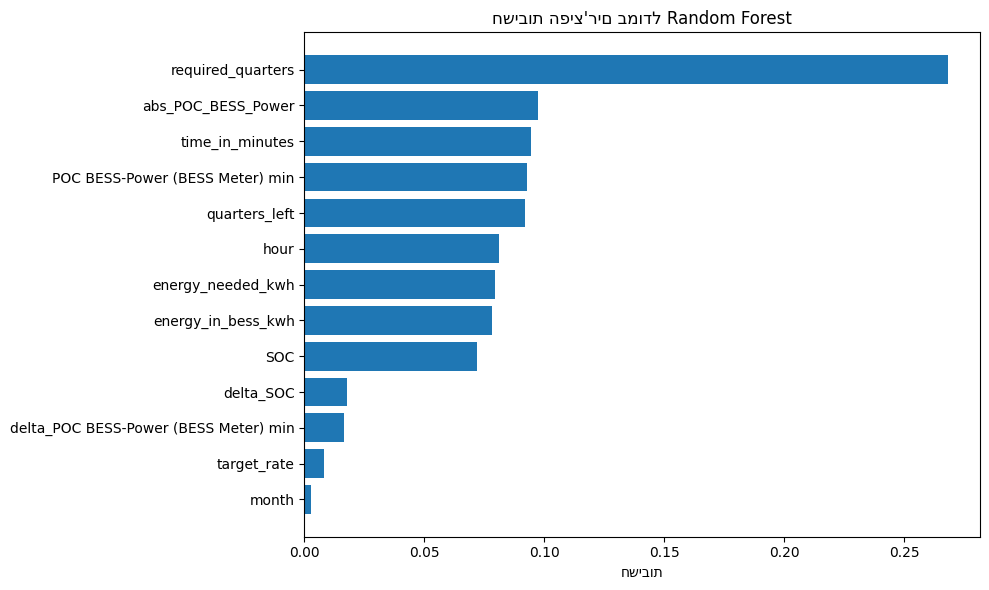

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# חישוב חשיבות הפיצ'רים
importances = model.feature_importances_

feat_imp = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# הדפסה
print(feat_imp)

# גרף
plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.gca().invert_yaxis()
plt.xlabel("חשיבות")
plt.title("חשיבות הפיצ'רים במודל Random Forest")
plt.tight_layout()
plt.show()

עכשיו אחרי שראיתי את חשיבות הפיצרים אני רוצה להוריד כמה מהם במיוחד את הדלתאות ןאת furst_bess_act  שאני לא רוצה שהוא יתבסס עליו

                       Feature  Importance
3            required_quarters    0.375777
1                         hour    0.133156
4                quarters_left    0.125102
10          abs_POC_BESS_Power    0.124219
0                          SOC    0.075150
6           energy_in_bess_kwh    0.069965
5            energy_needed_kwh    0.063141
7     PV Meter-Exported Energy    0.010846
8   BESS Meter-Imported Energy    0.010356
9                           PR    0.009259
2                        month    0.003030


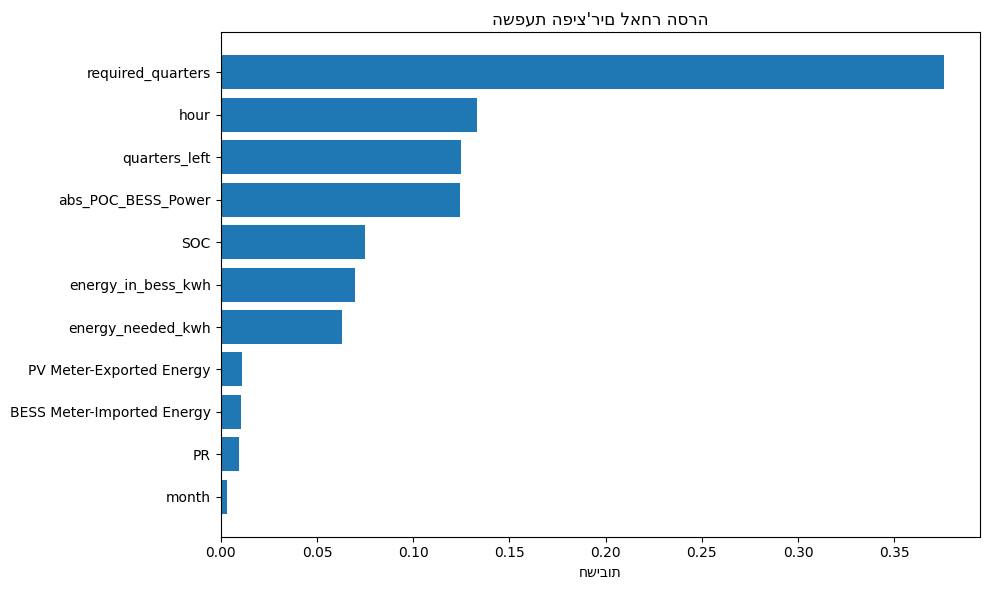


דיוק: 0.986
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       262
           1       0.99      0.98      0.99       324

    accuracy                           0.99       586
   macro avg       0.99      0.99      0.99       586
weighted avg       0.99      0.99      0.99       586



In [34]:
#selected_features = [
 #   'SOC', 'hour', 'month',
   # 'energy_needed_kwh', 'required_quarters','PV Meter-Exported Energy','delta_BESS Meter-Imported Energy',
   # 'quarters_left', 'time_in_minutes','BESS Meter-Imported Energy',
#]

selected_features = [
    'SOC', 'hour', 'month','required_quarters','quarters_left','energy_needed_kwh','energy_in_bess_kwh',
    'PV Meter-Exported Energy',
    'BESS Meter-Imported Energy','PR','abs_POC_BESS_Power'
]

df_filtered = df[(df['hour'] >= 9) & (df['hour'] < 16)].dropna(subset=['BESS First'])
X = df_filtered [selected_features]
y = df_filtered ['BESS First']  # עמודת היעד שלך (0 או 1, לדוגמה)

# 3. חלוקה לאימון ובדיקה (לא חובה אם כבר הכל מוכן)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. אימון המודל
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
importances = model.feature_importances_
feat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# הדפסה וגרף
print(feat_imp)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.gca().invert_yaxis()
plt.title("השפעת הפיצ'רים לאחר הסרה")
plt.xlabel("חשיבות")
plt.tight_layout()
plt.show()
# תחזית על סט הבדיקה
y_pred = model.predict(X_test)

# דוח ביצועים
from sklearn.metrics import classification_report, accuracy_score

print(f"\nדיוק: {accuracy_score(y_test, y_pred):.3f}")
print(classification_report(y_test, y_pred))

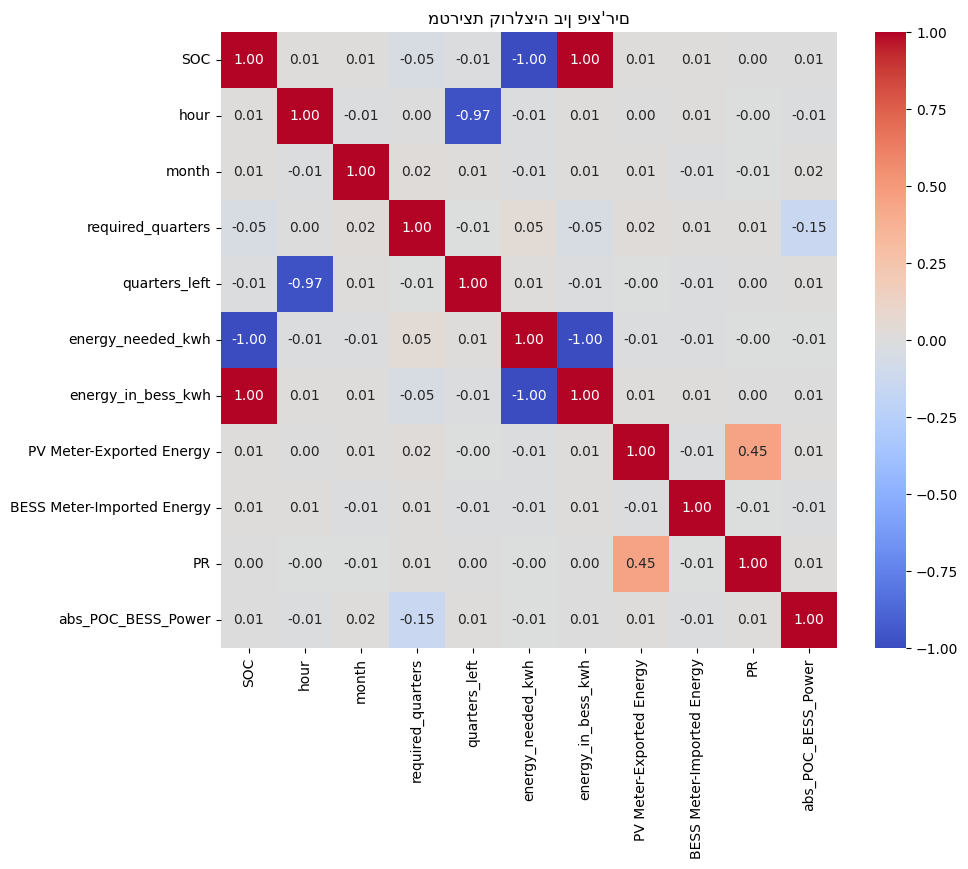

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df[selected_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("מטריצת קורלציה בין פיצ'רים")
plt.show()

              Feature  Importance
3   required_quarters    0.360314
6  abs_POC_BESS_Power    0.143940
4       quarters_left    0.143085
1                hour    0.121518
0                 SOC    0.119250
5   energy_needed_kwh    0.109057
2               month    0.002836


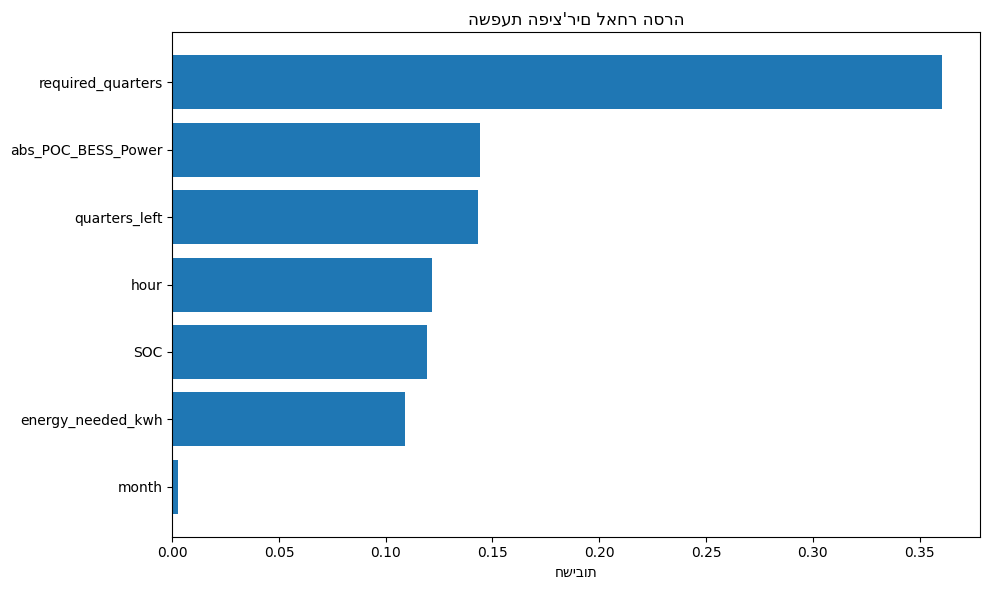


דיוק: 0.986
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       262
           1       1.00      0.98      0.99       324

    accuracy                           0.99       586
   macro avg       0.99      0.99      0.99       586
weighted avg       0.99      0.99      0.99       586



In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

#X_train, X_test, y_train, y_test = train_test_split(
   # X[selected_features], y, test_size=0.2, stratify=y, random_state=42)



selected_features = [
    'SOC', 'hour', 'month','required_quarters','quarters_left','energy_needed_kwh'
    ,'abs_POC_BESS_Power'
]

df_filtered = df[(df['hour'] >= 9) & (df['hour'] < 16)].dropna(subset=['BESS First'])
X = df_filtered [selected_features]
y = df_filtered ['BESS First']  # עמודת היעד שלך (0 או 1, לדוגמה)

# 3. חלוקה לאימון ובדיקה (לא חובה אם כבר הכל מוכן)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. אימון המודל

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=2,
    max_leaf_nodes=50,
    random_state=42
)


#model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
importances = model.feature_importances_
feat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# הדפסה וגרף
print(feat_imp)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.gca().invert_yaxis()
plt.title("השפעת הפיצ'רים לאחר הסרה")
plt.xlabel("חשיבות")
plt.tight_layout()
plt.show()
# תחזית על סט הבדיקה
y_pred = model.predict(X_test)

# דוח ביצועים
from sklearn.metrics import classification_report, accuracy_score

print(f"\nדיוק: {accuracy_score(y_test, y_pred):.3f}")
print(classification_report(y_test, y_pred))

              Feature  Importance
3   required_quarters    0.347076
6  abs_POC_BESS_Power    0.151975
4       quarters_left    0.145870
1                hour    0.132985
0                 SOC    0.112505
5   energy_needed_kwh    0.106833
2               month    0.002757


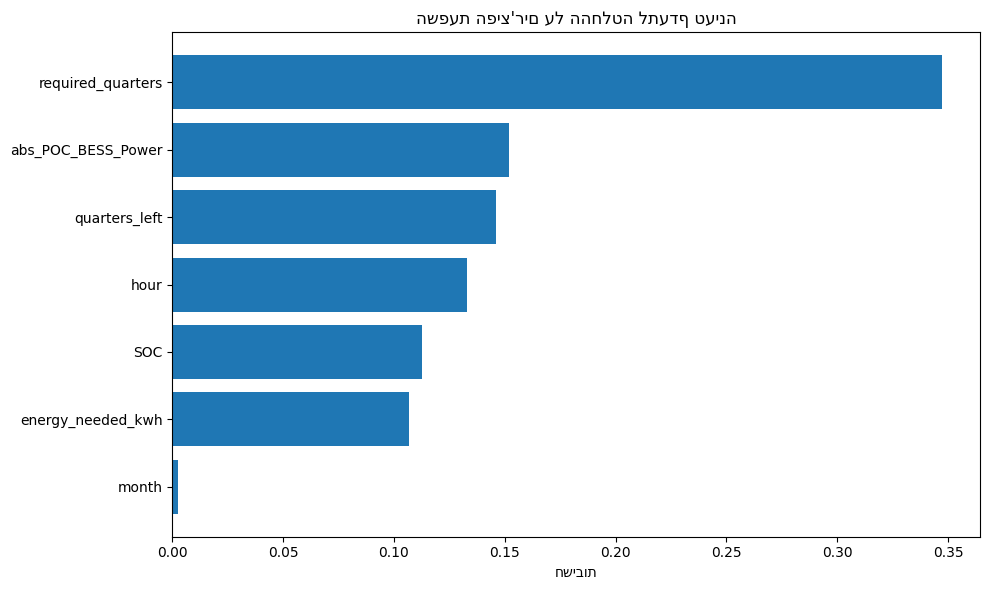


דיוק (Accuracy): 0.983
דוח סיווג:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       266
           1       0.98      0.98      0.98       320

    accuracy                           0.98       586
   macro avg       0.98      0.98      0.98       586
weighted avg       0.98      0.98      0.98       586



In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import pandas as pd

# ---------------------------------------------------
# 🎯 הגדרת הפיצ'רים — בלי לכלול את 'BESS First' כפיצ'ר!
# ---------------------------------------------------
selected_features = [
    'SOC', 'hour', 'month',
    'required_quarters',        # נגזר מתוך SOC ו־grid limit
    'quarters_left',            # נגזר מתוך השעה
    'energy_needed_kwh',        # נגזר מתוך SOC
   # 'BESS Meter-Imported Energy', # מדד צריכה מצטברת (מהשטח)
    'abs_POC_BESS_Power'
]

df_filtered = df[(df['hour'] >= 9) & (df['hour'] < 16)].dropna(subset=['BESS First'])
X = df_filtered [selected_features]
y = df_filtered ['BESS First']   # ✅ משתנה מטרה – נוצר לפי נוסחה: required > left

# ---------------------------------------------------
# 📤 חלוקה לאימון ובדיקה (אפשר להוסיף stratify)
# ---------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------------------------------------------------
# 🌲 אימון מודל יער אקראי
# ---------------------------------------------------
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=2,
    max_leaf_nodes=50,
    random_state=42
)
model.fit(X_train, y_train)

# ---------------------------------------------------
# 📊 חשיבות הפיצ'רים
# ---------------------------------------------------
importances = model.feature_importances_
feat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp['Feature'], feat_imp['Importance'])
plt.gca().invert_yaxis()
plt.title("השפעת הפיצ'רים על ההחלטה לתעדף טעינה")
plt.xlabel("חשיבות")
plt.tight_layout()
plt.show()

# ---------------------------------------------------
# 🎯 תחזית ובדיקת דיוק
# ---------------------------------------------------
y_pred = model.predict(X_test)

print(f"\nדיוק (Accuracy): {accuracy_score(y_test, y_pred):.3f}")
print("דוח סיווג:")
print(classification_report(y_test, y_pred))


In [38]:
print(f"len(y_test): {len(y_test)}")
print(f"len(y_pred): {len(y_pred)}")

print("האם יש שוני בין y_test ל־y_pred?")
print((y_test != y_pred).sum())

len(y_test): 586
len(y_pred): 586
האם יש שוני בין y_test ל־y_pred?
10


In [39]:
import joblib
joblib.dump(model, 'bess_priority_model2.pkl')

['bess_priority_model2.pkl']

In [40]:
import numpy as np
import pandas as pd
import joblib

# רשימת הפיצ'רים (חייבת להתאים לסדר שבו המודל אומן!)
selected_features = [
    'SOC',
    'hour',
    'month',
    'energy_needed_kwh',
    'required_quarters',
    'quarters_left',
    'abs_POC_BESS_Power',
    #'BESS Meter-Imported Energy',
    #'BESS First'  # ← כאן מוסיפים אותו
]

# נתוני אתר קבועים
site_capacity_kwp = 15200
grid_connection_limit_kw = 6000
bess_capacity_kwh = 0.99 * 35000  # SOC יעד
bess_charge_limit_kw = 6000

# פונקציית בניית פיצ'רים
def prepare_features(input_dict):
    soc = input_dict['soc']
    hour = input_dict['hour']
    month = input_dict['month']
   # bess_imported = input_dict['BESS Meter-Imported Energy']



    BESS_Power = input_dict.get('abs_POC_BESS_Power', 0)
    if BESS_Power == 0:
        BESS_Power = 1

    energy_needed_kwh = bess_capacity_kwh * (1 - soc / 100)
    #required_quarters = np.ceil((energy_needed_kwh / grid_connection_limit_kw) * 4)
    required_quarters = np.ceil((energy_needed_kwh / BESS_Power) * 4)
    quarters_left = max(0, (16 - hour) * 4)

    bess_first = int(required_quarters > quarters_left)

    input_dict_full = {
        'SOC': soc,
        'hour': hour,
        'month': month,
        'energy_needed_kwh': energy_needed_kwh,
        'required_quarters': required_quarters,
        'quarters_left': quarters_left,
        'abs_POC_BESS_Power':BESS_Power,
   #    'BESS Meter-Imported Energy': bess_imported,
        'BESS First': bess_first# ← ✨ הפיצ'ר הקריטי
    }

    features = {key: input_dict_full[key] for key in selected_features}
    return pd.DataFrame([features])

    # יצירת DataFrame בסדר עמודות מדויק כפי שהמודל אומן עליו
    return pd.DataFrame([input_dict_full])[selected_features]

# טעינת המודל המאומן
model = joblib.load("bess_priority_model2.pkl")
selected_features = list(model.feature_names_in_)

# סוכן שמקבל החלטה

def decide_bess_priority(input_dict):
    features_df = prepare_features(input_dict)

    # שמות שהמודל מצפה להם
    expected_features = list(model.feature_names_in_)
    # שמות שהגיעו בפועל
    actual_features = list(features_df.columns)

    # בדיקה אם יש חוסר או עודפים
    missing = [f for f in expected_features if f not in actual_features]
    extra = [f for f in actual_features if f not in expected_features]
    order_wrong = expected_features != actual_features

    # הדפסת פערים
    if missing:
        print("❌ פיצ'רים חסרים בדאטה:", missing)
    if extra:
        print("⚠️ פיצ'רים מיותרים בדאטה:", extra)
    if order_wrong and not missing and not extra:
        print("⚠️ סדר הפיצ'רים שונה ממה שהמודל ציפה לו.")
        print("מצופה:", expected_features)
        print("אבל בפועל:", actual_features)

    if missing or extra or order_wrong:
        print("⛔ לא נבצע תחזית עד שהפער יתוקן.")
        return "שגיאה: נתוני קלט לא תואמים למודל"

    # אם הכול תקין – נבצע תחזית
    prediction = model.predict(features_df)[0]
    return "✅ טעינת BESS בעדיפות" if prediction == 1 else "🟡 אין צורך בעדיפות ל־BESS"

# דוגמה לשימוש
sample_input = {
    'soc': 1,
    'hour': 12,
    'month': 4,
    'BESS_Power': 5000,
}

# הדפסת ההחלטה
print(decide_bess_priority(sample_input))

✅ טעינת BESS בעדיפות


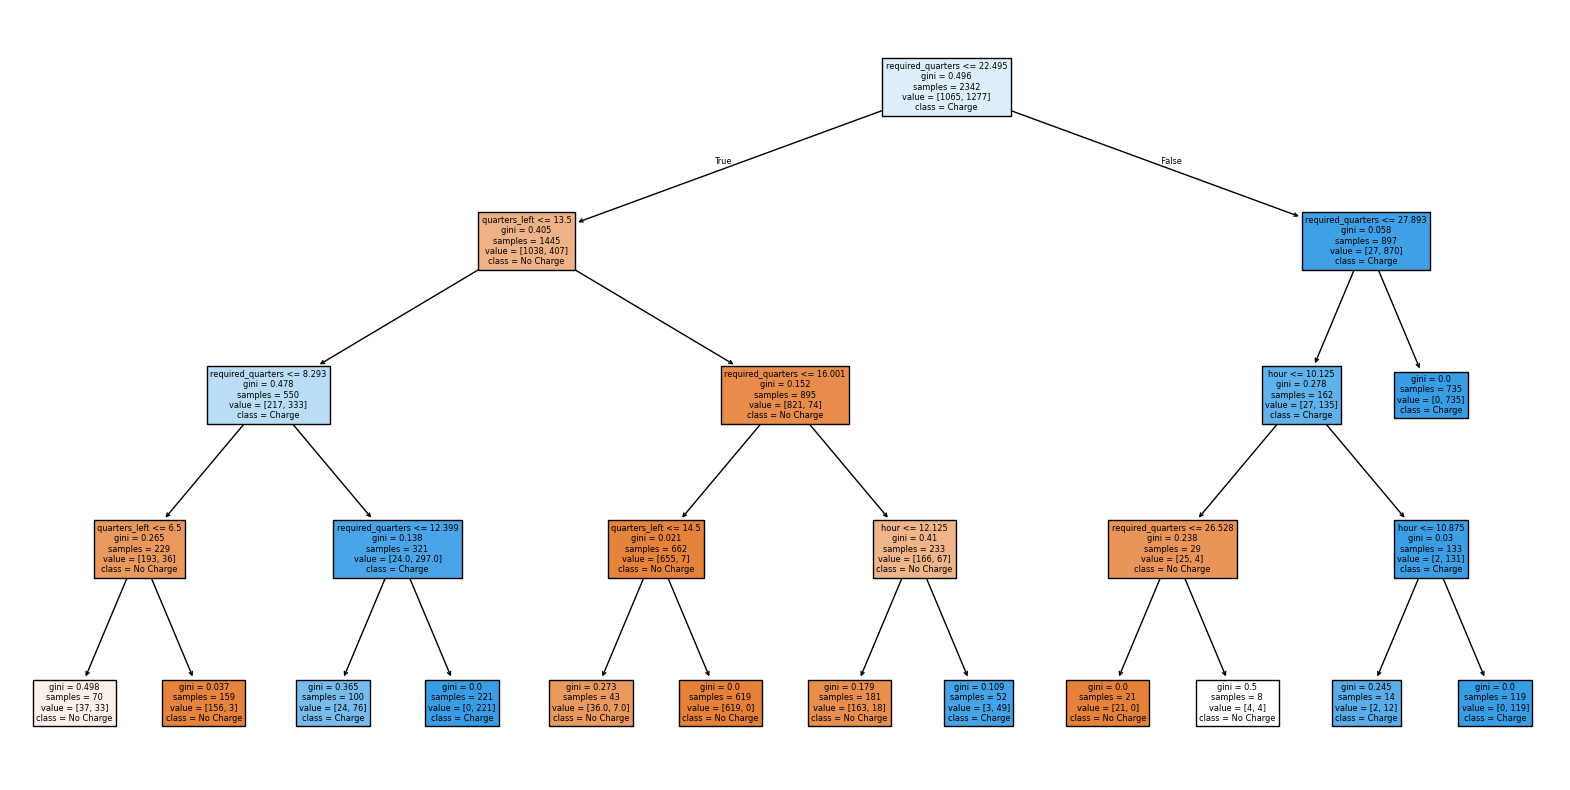

In [41]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# אימון עץ החלטה פשוט
dt_model = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_model.fit(X_train, y_train)

# ציור העץ
plt.figure(figsize=(20,10))
plot_tree(dt_model, feature_names=X.columns, class_names=['No Charge', 'Charge'], filled=True)
plt.show()

In [42]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(
    dt_model, out_file=None,
    feature_names=X.columns,
    class_names=['No Charge', 'Charge'],
    filled=True, rounded=True,
    special_characters=True
)
graph = graphviz.Source(dot_data)
graph.render("decision_tree")  # ייצור קובץ

'decision_tree.pdf'

In [43]:
def interactive_decision(soc, hour, month, BESS_Power):
    input_dict = {
        'soc': soc,
        'hour': hour,
        'month': month,
        #'BESS Meter-Imported Energy': bess_imported
        'abs_POC_BESS_Power':BESS_Power
    }

    features_df = prepare_features(input_dict)
    prediction = model.predict(features_df)[0]

    print("📊 פיצ'רים שחושבו למודל:")
    display(features_df)

    print(f"🔍 תוצאת המודל (raw): {prediction}")

    if prediction == 1:
        result = "✅ טעינת BESS בעדיפות"
    elif prediction == 0:
        result = "🟡 אין צורך בעדיפות ל־BESS"
    else:
        result = "⚠️ שגיאה: תחזית לא צפויה מהמודל"

    print("🔍 תוצאה:", result)

In [44]:
from ipywidgets import interact, IntSlider
interact(
    interactive_decision,
    soc=IntSlider(min=0, max=100, value=75),
    hour=IntSlider(min=9, max=16, value=12),
    month=IntSlider(min=1, max=12, value=4),
    BESS_Power=IntSlider(min=0, max=6000, value=5000)
)

interactive(children=(IntSlider(value=75, description='soc'), IntSlider(value=12, description='hour', max=16, …

<function __main__.interactive_decision(soc, hour, month, BESS_Power)>